In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import tensorflow as tf
print('TF Version: ' + str(tf.__version__))
physical_devices = tf.config.list_physical_devices('GPU')
print('GPUs: ' + str(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

TF Version: 2.9.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# todo why MNIST performance worse as COIL100 -> MNIST numbers have natural tilts anyway which makes the fine-grain angle prediction nearly impossible

import math
import seaborn as sns
import tensorflow_addons as tfa
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from src.model import VGG11
from src.utils import angle_between
from src.model import BIC
from src.parsing import load_dataset
from src.parsing import preprocess
from src.parsing import instantiate_radial_beams

In [3]:
dataset_name = 'mnist'
target_size = 28 // 2
model_path = './model/mnist_off_16_False.h5'
margin_padding = math.ceil(target_size * (math.sqrt(2) - 1))
batch_size = 128
n_beams = 16
continuous = False

### Load datasets
Reminder: First, load, pre-process and store a dataset via the [RadialBeam](./radialbeamsampling.ipynb) routine.

In [4]:
en_load_dataset = False

if en_load_dataset:
    train_dataset = tf.data.experimental.load('./data/{0}_train'.format(dataset_name)).batch(batch_size)
    val_dataset = tf.data.experimental.load('./data/{0}_val'.format(dataset_name)).batch(batch_size)
    test_dataset = tf.data.experimental.load('./data/{0}_test'.format(dataset_name)).batch(batch_size)
else:
    splits = [0.8, 0.1, 0.1]
    dataset = load_dataset(dataset_name)

    if dataset_name == 'mnist':
        # remove 9 from MNIST since equal 6 if rotated
        # filter function of tf.data does not seem to work
        images, labels, = [], []
        for d, data in enumerate(dataset):
            print('Filtering MNIST {0}/{1}'.format(d, dataset.cardinality() - 1), end='\r')
            if data['label'] != 9:
                images.append(data['image'])
                labels.append(data['label'])
        dataset = tf.data.Dataset.from_tensor_slices({'image': images, 'label': labels})

    n_train = int(splits[0] * float(dataset.cardinality()))
    n_val = int(splits[1] * float(dataset.cardinality()))
    n_test = int(splits[2] * float(dataset.cardinality()))

    canonic_train_dataset = dataset.take(n_train)
    canonic_val_dataset = dataset.skip(n_train).take(n_val)
    canonic_test_dataset = dataset.skip(n_train).skip(n_val).take(n_train)

    img_size = int(canonic_train_dataset.element_spec['image'].shape[0])
    lines, angles = instantiate_radial_beams(img_size + margin_padding, img_size + margin_padding,
                                             beam_set_size=n_beams,
                                             max_len=target_size)
    train_dataset = preprocess(canonic_train_dataset, lines, angles, target_size=img_size + margin_padding,
                               batch_size=batch_size, path='./training_dataset', continuous=continuous)
    val_dataset = preprocess(canonic_val_dataset, lines, angles, target_size=img_size + margin_padding,
                             batch_size=batch_size, path='./val_dataset', continuous=continuous)
    test_dataset = preprocess(canonic_test_dataset, lines, angles, target_size=img_size + margin_padding,
                              batch_size=batch_size, path='./test_dataset', continuous=continuous)

_, n_beams, _, n_pixels, n_channels = train_dataset.element_spec['beam'].shape

2023-03-17 10:28:33.557241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 10:28:34.778335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43660 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:43:00.0, compute capability: 8.6


Padding mode default9/59999
Padding mode default
Padding mode default


### Load the BIC model

In [5]:
# input tensor (batch x (zero, theta) x beams x (2epsilon + 1) x D x C)
in_beams = tf.keras.layers.Input([2, n_beams, 3, n_pixels, n_channels])

bic = BIC(hidden=128, activation=tf.nn.leaky_relu, context=True,
          l2_regularization=0.0, edge_factor=0.5, gcn_layers=3, dropout=0.0,
          n_beams=n_beams, pixel_count_per_beam=n_pixels)

# multiple output for introspection; for training and inference: prior and unit_vec are essential
prior, unit_vec, beamencoding, ctx, similarity, \
beamencoding_zero, beamencoding_theta, angle_energy, rnn_encoding = bic(inputs=in_beams)

# bic = bic.save_weights(model_path)
bic.load_weights(model_path)
bic.summary()

Model: "bic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 beam_encoder (BeamEncoder)  multiple                  51648     
                                                                 
 graph_convolution_layer (Gr  multiple                 16384     
 aphConvolutionLayer)                                            
                                                                 
 graph_convolution_layer_1 (  multiple                 16384     
 GraphConvolutionLayer)                                          
                                                                 
 graph_convolution_layer_2 (  multiple                 16384     
 GraphConvolutionLayer)                                          
                                                                 
 lstm0 (LSTM)                multiple                  131584    
                                                               

### Crop and canonicalize methods

In [6]:
def remove_padding(image):
    cropped_image = tf.image.crop_to_bounding_box(image, margin_padding // 2, margin_padding // 2,
                                                  target_size * 2, target_size * 2)
    return cropped_image


def downstream_predict(downstream, sample, k=1, show=False):
    # predict non-rotated image with downstream model
    if k == 1:
        non_rot_pred = downstream(remove_padding(sample['image']))
    else:
        non_rot_pred = tf.nn.top_k(downstream(remove_padding(sample['image'])), k=k)

    # predict rotated and chopped off image
    if k == 1:
        crop_rot_pred = downstream(remove_padding(sample['rotated']))
    else:
        crop_rot_pred = tf.nn.top_k(downstream(remove_padding(sample['rotated'])), k=k)

    # call BIC
    pred_facts, pred_angle, conv_latents, gnn_latents, distance_matrix, \
    x1_emb, x2_emb, angle_energy, rnn_encoding = bic(
        tf.tile(sample['beam_rot'][:, None, ...], [1, 2, 1, 1, 1, 1]))

    # project form complex vector to angle
    pred_angle = np.array([angle_between(pred_angle[b], tf.cast([1., 0.], tf.float32), gpu=True)
                           for b in range(tf.shape(pred_angle)[0])])

    # smoothly rotate the image back
    back_rot = tfa.image.rotate(sample['rotated'], 2 * math.pi - pred_angle,
                                interpolation='bilinear')

    # predict with downstream model
    if k == 1:
        if show:
            plt.imshow(remove_padding(back_rot[0]))
            plt.show()
        canonic_pred = downstream(remove_padding(back_rot))
    else:
        canonic_pred = tf.nn.top_k(downstream(remove_padding(back_rot)), k=k)

    return non_rot_pred, crop_rot_pred, canonic_pred

In [7]:
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
train_df = pd.DataFrame(columns=['iteration', 'non_rot_loss', 'crop_rot_loss', 'canonic_loss'])
valid_df = pd.DataFrame(columns=['iteration', 'non_rot_loss', 'crop_rot_loss', 'canonic_loss'])

In [24]:
downstream = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', name='1'),
  tf.keras.layers.Dense(9, activation='softmax', name='2')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
for e in range(2):
    acc = []
    for i, sample in enumerate(canonic_train_dataset.batch(batch_size)):
        with tf.GradientTape() as tape:
            pred = downstream(sample['image'])
            loss = cce(sample['label'], pred)
        grads_downstream = tape.gradient(loss, downstream.trainable_variables)
        optimizer.apply_gradients(zip(grads_downstream, downstream.trainable_variables))
        acc.extend(np.array(tf.argmax(pred, axis=-1) == sample['label']).tolist())
    print("Train Acc: {}".format(np.mean(acc)))

Train Acc: 0.7859158186864015
Train Acc: 0.8840888066604995


  0%|                                                                                                                              | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_339342/3179853102.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(pd.DataFrame({


Train Acc: 0.8397086031452359


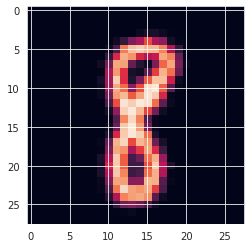

/tmp/ipykernel_339342/3179853102.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(pd.DataFrame({


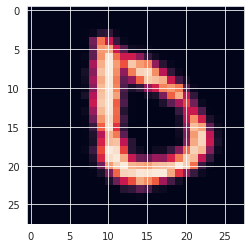

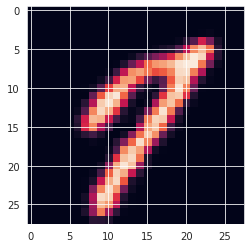

 50%|███████████████████████████████████████████████████████████                                                           | 1/2 [01:10<01:10, 70.15s/it]

Val Acc: 0.8614246068455134
Train Acc: 0.8785152636447734


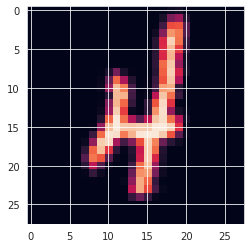

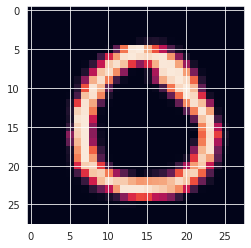

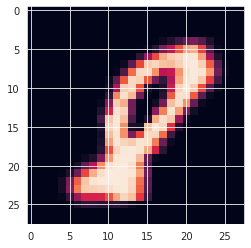

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:20<00:00, 70.12s/it]

Val Acc: 0.8819611470860315


In [26]:
n_runs = 1
epochs = 2

for _ in range(n_runs):
    downstream = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu', name='1'),
      tf.keras.layers.Dense(9, activation='softmax', name='2')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    for e in tqdm(range(epochs)):

        # training
        acc = []
        for i, sample in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                non_rot_pred, crop_rot_pred, canonic_pred = downstream_predict(downstream, sample,
                                                                               show=False)#True if i == 0 else False)
                loss = cce(sample['label'], non_rot_pred)
                train_df = train_df.append(pd.DataFrame({
                    'iteration': [e * int(train_dataset.cardinality().numpy()) + i],
                    'non_rot_loss': [float(cce(sample['label'], non_rot_pred).numpy())],
                    'crop_rot_loss': [float(cce(sample['label'], crop_rot_pred).numpy())],
                    'canonic_loss': [float(cce(sample['label'], canonic_pred).numpy())]
                }), ignore_index=True)
            grads_downstream = tape.gradient(loss, downstream.trainable_variables)
            optimizer.apply_gradients(zip(grads_downstream, downstream.trainable_variables))
            acc.extend(np.array(tf.argmax(canonic_pred, axis=-1) == sample['label']).tolist())
        print("Train Acc: {}".format(np.mean(acc)))

        # validation, before training to log also the init behaviour of the model
        acc = []
        for i, sample in enumerate(val_dataset):
            non_rot_pred, crop_rot_pred, canonic_pred = downstream_predict(downstream, sample, show=True if i < 3 else False)
            valid_df = valid_df.append(pd.DataFrame({
                'iteration': [e * int(val_dataset.cardinality().numpy()) + i],
                'non_rot_loss': [float(cce(sample['label'], non_rot_pred).numpy())],
                'crop_rot_loss': [float(cce(sample['label'], crop_rot_pred).numpy())],
                'canonic_loss': [float(cce(sample['label'], canonic_pred).numpy())]
            }), ignore_index=True)
            acc.extend(np.array(tf.argmax(canonic_pred, axis=-1) == sample['label']).tolist())
        print("Val Acc: {}".format(np.mean(acc)))

In [ ]:
colors = ['#629FCA', '#FDA556', '#6BBC6B', '#E26768', '#B292CE']

ax = sns.lineplot(data=train_df, x='iteration', y='non_rot_loss', label='non_rot_loss', ci='sd',
             palette=colors[0], alpha=0.7)
ax = sns.lineplot(data=train_df, x='iteration', y='crop_rot_loss', label='crop_rot_loss', ci='sd',
             palette=colors[1], alpha=0.7)
ax = sns.lineplot(data=train_df, x='iteration', y='canonic_loss', label='canonic_loss', ci='sd',
             palette=colors[2], alpha=0.7)

ax.set_ylabel('Cross Entropy')
ax.legend().remove()
plt.show()